In [297]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from dateutil.parser import parse
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sohnnick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***Read in CSV Files***

In [298]:
df_metricsandvalue = pd.read_csv("df_stockmovement.csv")
df_metricsandvalue = df_metricsandvalue.loc[:, 'Date':'rt5']
df_metricsandvalue.head(5)

,Date,OPEN,HIGH,LOW,VOLUME,CLOSE,rt3,rt5
0,2013-08-26,30.810515,30.968887,30.676139,5472400,30.676139,-0.003582,0.009133
1,2013-08-27,30.359395,30.589756,30.133837,4870800,30.143435,0.003485,0.040384
2,2013-08-28,30.100242,30.570559,30.066649,6044000,30.412186,0.017891,0.035149
3,2013-08-29,30.330330,30.749243,30.277363,4600000,30.566269,0.025992,0.023630
4,2013-08-30,30.677016,30.715537,30.142539,5851000,30.248472,0.040751,0.041070


In [299]:
df_tfidf = pd.read_csv("df_tfidf.csv")
df_tfidf = df_tfidf.loc[:, 'date':'0.51']
df_tfidf.head(5)

,date,lot,stocks,trading,green,EVP,CFO,cashed-in,options,China,...,Brean,DWTI,lights,7x,5x,E2,https,NKE/,ApparelAndAccessories,0.51
0,2013-12-03,2.655833,1.212015,1.956129,2.134536,3.942044,4.153353,3.094746,1.89897,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-12-04,2.655833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.371446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-12-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-12-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-12-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [300]:
df_volume = pd.read_csv("df_volumemetrics.csv")
df_volume = df_volume.loc[:, 'date':'mv10t']
df_volume.head(5)

,date,polarity,st,msgvolume,mv1t,mv10t
0,2013-12-03,0.000000,NaN,2,NaN,NaN
1,2013-12-04,0.200000,NaN,5,1.500000,NaN
2,2013-12-05,0.111111,0.103704,9,0.800000,NaN
3,2013-12-06,0.000000,0.103704,2,-0.777778,NaN
4,2013-12-07,0.000000,0.037037,3,0.500000,NaN


***Naive-Bayes Classification***

In [301]:
df_target = df_metricsandvalue[['Date', 'rt3', 'rt5']][:823]
df_target.columns = ['date', 'rt3', 'rt5']

In [302]:
df_target['rt3'][df_target['rt3'] > 0] = 1
df_target['rt3'][df_target['rt3'] <= 0] = 0
df_target['rt5'][df_target['rt5'] > 0] = 1
df_target['rt5'][df_target['rt5'] <= 0] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [303]:
df_tfidf['date'] = pd.to_datetime(df_tfidf['date'])
df_target['date'] = pd.to_datetime(df_target['date'])
df_merge = pd.merge(df_tfidf, df_target, on='date', how='inner')
df_merge.shape

(753, 1485)

In [304]:
#confirms that the merge worked
targetdate = list(df_target['date'])
tfidfdate = list(df_tfidf['date'])
len(set(targetdate) & set(tfidfdate))

753

Feature Selection

In [305]:
features= list(df_merge.columns)
features.remove('date')
features.remove('rt3')
features.remove('rt5')
rt3features = sklearn.feature_selection.chi2(df_merge[features], df_merge['rt3'])
rt5features = sklearn.feature_selection.chi2(df_merge[features], df_merge['rt5'])
rt3selected = []
rt5selected = []
for i in range(0,len(features)):
    if rt3features[1][i] < 0.1:
        rt3selected.append(features[i])
    if rt5features[1][i] < 0.1:
        rt5selected.append(features[i])

Train/Test Split

In [306]:
lendf = len(df_merge)
crit = int(np.floor(lendf*2/3))
df_train = df_merge[:crit]
df_test = df_merge[crit:]

#extract train x and y
xrt3_train = df_train[rt3selected]
xrt5_train = df_train[rt5selected]
yrt3_train = df_train['rt3']
yrt5_train = df_train['rt5']

#extract test x and y
xrt3_test = df_test[rt3selected]
xrt5_test = df_test[rt5selected]
yrt3_test = df_test['rt3']
yrt5_test = df_test['rt5']

Naive Bayes Classifier

In [307]:
def GNB(xfit, yfit, xpred, ypred):
    #fit NB based on parameter
    gnb = GaussianNB()
    gnb.fit(xfit, yfit)
    
    #predict based on parameter
    y_pred = gnb.predict(xpred)
    ylist = list(ypred)
    ypredlist = list(y_pred)
    count = 0
    for i in range(0, len(ypredlist)):
        if ylist[i] == ypredlist[i]:
            count = count + 1
    print('Accuracy:', count/len(ypredlist))
    return count/len(ypredlist)

Accuracy

In [308]:
print('Train Accuracy rt3')
nb_rt3train_acc = GNB(xrt3_train, yrt3_train, xrt3_train, yrt3_train)
print('\nTrain Accuracy rt5')
nb_rt5train_acc = GNB(xrt5_train, yrt5_train, xrt5_train, yrt5_train)
print('\nTest Accuracy rt3')
nb_rt3test_acc = GNB(xrt3_train, yrt3_train, xrt3_test, yrt3_test)
print('\nTest Accuracy rt5')
nb_rt5test_acc = GNB(xrt5_train, yrt5_train, xrt5_test, yrt5_test)

Train Accuracy rt3
Accuracy: 0.7270916334661355

Train Accuracy rt5
Accuracy: 0.6175298804780877

Test Accuracy rt3
Accuracy: 0.5258964143426295

Test Accuracy rt5
Accuracy: 0.4701195219123506


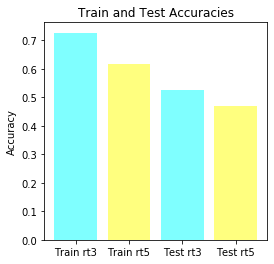

In [309]:
objects = ('Train rt3', 'Train rt5', 'Test rt3', 'Test rt5')
performance = [nb_rt3train_acc, nb_rt5train_acc, nb_rt3test_acc, nb_rt5test_acc]
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['cyan', 'yellow', 'cyan', 'yellow'])
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies')
plt.rcParams["figure.figsize"] = (4,4)

plt.show()

As we see from this graph, the model is quite overfit. The stock movement prediction for both the 3 day and 5 day price change showcased significant difference between train and test accuracies.

***Logistic Regression***

Frame Database

In [310]:
df_tfidf['date'] = pd.to_datetime(df_tfidf['date'])
df_volume['date'] = pd.to_datetime(df_volume['date'])
df_target['date'] = pd.to_datetime(df_target['date'])
df_temp = pd.merge(df_tfidf, df_volume, on='date', how='inner')
df_merge = pd.merge(df_temp, df_target, on='date', how='inner')
df_merge = df_merge[10:]
save_merge = df_merge
df_merge.shape

(743, 1490)

Train/Test Split

In [311]:
add = ['st', 'mv1t', 'mv10t']

In [312]:
lendf = len(df_merge)
crit = int(np.floor(lendf*2/3))
df_train = df_merge[:crit]
df_test = df_merge[crit:]

#extract train x and y
xrt3_train = df_train[rt3selected + add]
xrt5_train = df_train[rt5selected + add]
yrt3_train = df_train['rt3']
yrt5_train = df_train['rt5']

#extract test x and y
xrt3_test = df_test[rt3selected + add]
xrt5_test = df_test[rt5selected + add]
yrt3_test = df_test['rt3']
yrt5_test = df_test['rt5']

Logistic Regression

In [313]:
def logisticreg_accuracy(x_train, y_train, x_test, y_test):   
    clf = LogisticRegression().fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    ypredlist = list(y_pred)
    ytestlist = list(y_test)
    count = 0
    for i in range(0, len(ypredlist)):
        if ypredlist[i] == ytestlist[i]:
            count = count+1
    print(count/len(ypredlist))
    return count/len(ypredlist)

Train Error for rt3

In [314]:
print('Train Accuracy rt3')
lr_rt3train_acc = logisticreg_accuracy(xrt3_train, yrt3_train, xrt3_train, yrt3_train)
print('\nTrain Accuracy rt5')
lr_rt5train_acc = logisticreg_accuracy(xrt5_train, yrt5_train, xrt5_train, yrt5_train)
print('\nTest Accuracy rt3')
lr_rt3test_acc = logisticreg_accuracy(xrt3_train, yrt3_train, xrt3_test, yrt3_test)
print('\nTest Accuracy rt5')
lr_rt5test_acc = logisticreg_accuracy(xrt5_train, yrt5_train, xrt5_test, yrt5_test)

Train Accuracy rt3
0.997979797979798

Train Accuracy rt5
1.0

Test Accuracy rt3
0.4959677419354839

Test Accuracy rt5
0.4475806451612903


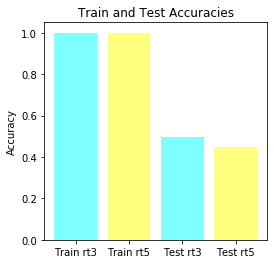

In [315]:
objects = ('Train rt3', 'Train rt5', 'Test rt3', 'Test rt5')
performance = [lr_rt3train_acc, lr_rt5train_acc, lr_rt3test_acc, lr_rt5test_acc]
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['cyan', 'yellow', 'cyan', 'yellow'])
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies')

plt.rcParams["figure.figsize"] = (2,4)
plt.show()

***Linear Regression***

Database Restructure

In [316]:
df_tfidf['date'] = pd.to_datetime(df_tfidf['date'])
df_volume['date'] = pd.to_datetime(df_volume['date'])
df_target['date'] = pd.to_datetime(df_target['date'])
df_temp = pd.merge(df_tfidf, df_volume, on='date', how='inner')
df_merge = pd.merge(df_temp, df_target, on='date', how='inner')
df_merge = df_merge[10:]
save_merge = df_merge
df_merge.shape

(743, 1490)

In [317]:
df_merge = df_merge.drop(['date', 'rt5', '0.51'], axis=1)

In [318]:
lendf = len(df_merge)
crit = int(np.floor(lendf*2/3))
df_train = df_merge[:crit]
df_test = df_merge[crit:]
df_xtrain = df_train.drop(['rt3'], axis=1)
df_xtest = df_test.drop(['rt3'], axis=1)
df_ytrain = df_train[['rt3']]
df_ytest = df_test[['rt3']]

OLS

In [319]:
def linear_reg(df_xtrain, df_ytrain, x, y):
    model = LinearRegression()
    model = LinearRegression().fit(df_xtrain, df_ytrain)
    y_pred = model.predict(x)
    rmse = mean_squared_error(y_pred, y, squared=False)
    r2 = r2_score(y, y_pred)
    return {'y_pred': y_pred, 'rmse': rmse, 'r2': r2}

In [320]:
train_results = linear_reg(df_xtrain, df_ytrain, df_xtrain, df_ytrain)
test_results = linear_reg(df_xtrain, df_ytrain, df_xtest, df_ytest)

Train Results

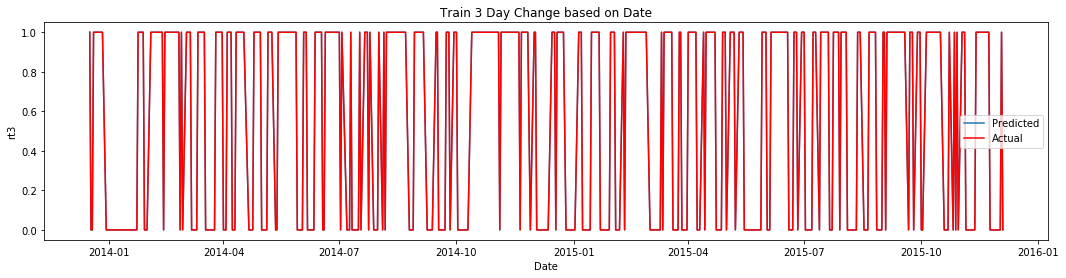

In [322]:
x = save_merge['date'][:crit]
y_pred = train_results['y_pred']
plt.plot(x,y_pred, label='Predicted')
plt.plot(x,df_ytrain, color='red', label='Actual')
plt.xlabel('Date')
plt.ylabel('rt3')
plt.title('Train 3 Day Change based on Date')
plt.legend()
plt.rcParams["figure.figsize"] = (20,4)

plt.show()

In [323]:
print('Root Mean Square Error:', train_results['rmse'])
print('R2:', train_results['r2'])

Root Mean Square Error: 3.601457078209576e-15
R2: 1.0


Test Results

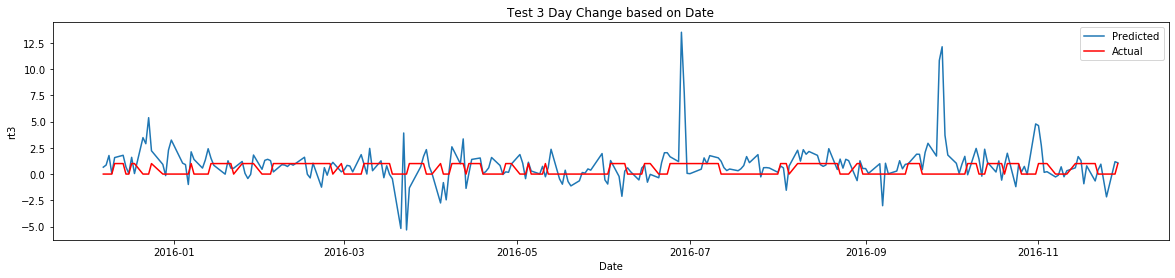

In [324]:
x = save_merge['date'][crit:]
y_pred = test_results['y_pred']
plt.plot(x,y_pred, label='Predicted')
plt.plot(x,df_ytest, color='red', label='Actual')
plt.xlabel('Date')
plt.ylabel('rt3')
plt.title('Test 3 Day Change based on Date')
plt.legend()
plt.rcParams["figure.figsize"] = (20,4)

plt.show()

In [325]:
print('Root Mean Square Error:', test_results['rmse'])
print('R2:', test_results['r2'])

Root Mean Square Error: 1.9338254631061882
R2: -14.124964517116824
